## Hypothesis:<br>

It is possible to predict the alignment (good, bad, neutral) of a character based on sex, hair color, eye color, number of appearances, and possibly using other features.

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns # visualizations
import matplotlib.pyplot as plt # visualizations

from sklearn.ensemble import RandomForestClassifier # Popular machine learning model for 
                                                    # classification problems.
from sklearn.model_selection import train_test_split # Divide data into training and testing subsets
from sklearn.model_selection import RandomizedSearchCV # hyperparameter tuning
from sklearn import metrics # model metrics
from jupyterthemes import jtplot # pretty themes 
jtplot.style(theme='chesterish') # pretty plots
%matplotlib inline

In [21]:
# Import data
marvel_data = pd.read_csv('dc-wikia-data.csv')
dc_data = pd.read_csv('marvel-wikia-data.csv')

## Data Dictionary:<br>
page_id = wiki page id. Probably will not help in classification and should drop<br>
name = Superhero name (citizen name)<br>
urlslug = url to the wiki page<br>
id = is the identify secret, public, unknown, no dual-identify, or known to authorities only?<br>
align = good, bad, neutral, reformed criminal<br>
eye = eye color<br>
hair = hair color<br>
sex = male, female, genderless, transgender, genderfluid, a-gender. <br>
gsm = sexual orientation<br>
alive = dead or no<br>
appearances = how many appearances the character has made<br>
first appearance = date of first appearance<br>
year = year of first appearance<br>

In [3]:
marvel_data.head()

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR
0,1422,Batman (Bruce Wayne),\/wiki\/Batman_(Bruce_Wayne),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,3093.0,"1939, May",1939.0
1,23387,Superman (Clark Kent),\/wiki\/Superman_(Clark_Kent),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,2496.0,"1986, October",1986.0
2,1458,Green Lantern (Hal Jordan),\/wiki\/Green_Lantern_(Hal_Jordan),Secret Identity,Good Characters,Brown Eyes,Brown Hair,Male Characters,NaN,Living Characters,1565.0,"1959, October",1959.0
3,1659,James Gordon (New Earth),\/wiki\/James_Gordon_(New_Earth),Public Identity,Good Characters,Brown Eyes,White Hair,Male Characters,NaN,Living Characters,1316.0,"1987, February",1987.0
4,1576,Richard Grayson (New Earth),\/wiki\/Richard_Grayson_(New_Earth),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,1237.0,"1940, April",1940.0


In [4]:
dc_data.head()

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,Year
0,1678,Spider-Man (Peter Parker),\/Spider-Man_(Peter_Parker),Secret Identity,Good Characters,Hazel Eyes,Brown Hair,Male Characters,NaN,Living Characters,4043.0,Aug-62,1962.0
1,7139,Captain America (Steven Rogers),\/Captain_America_(Steven_Rogers),Public Identity,Good Characters,Blue Eyes,White Hair,Male Characters,NaN,Living Characters,3360.0,Mar-41,1941.0
2,64786,"Wolverine (James \""Logan\"" Howlett)",\/Wolverine_(James_%22Logan%22_Howlett),Public Identity,Neutral Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,3061.0,Oct-74,1974.0
3,1868,"Iron Man (Anthony \""Tony\"" Stark)",\/Iron_Man_(Anthony_%22Tony%22_Stark),Public Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,2961.0,Mar-63,1963.0
4,2460,Thor (Thor Odinson),\/Thor_(Thor_Odinson),No Dual Identity,Good Characters,Blue Eyes,Blond Hair,Male Characters,NaN,Living Characters,2258.0,Nov-50,1950.0


In [22]:
# Feature columns are identical except the year column is caps in one and not the other. 
# Renaming the column allows us to concat the dataframes together. 
dc_data.rename(columns={'Year':'YEAR'}, inplace=True)
all_data = pd.concat([marvel_data, dc_data], sort=False).reset_index(drop=True)
all_data

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,GSM,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR
0,1422,Batman (Bruce Wayne),\/wiki\/Batman_(Bruce_Wayne),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,3093.0,"1939, May",1939.0
1,23387,Superman (Clark Kent),\/wiki\/Superman_(Clark_Kent),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,2496.0,"1986, October",1986.0
2,1458,Green Lantern (Hal Jordan),\/wiki\/Green_Lantern_(Hal_Jordan),Secret Identity,Good Characters,Brown Eyes,Brown Hair,Male Characters,NaN,Living Characters,1565.0,"1959, October",1959.0
3,1659,James Gordon (New Earth),\/wiki\/James_Gordon_(New_Earth),Public Identity,Good Characters,Brown Eyes,White Hair,Male Characters,NaN,Living Characters,1316.0,"1987, February",1987.0
4,1576,Richard Grayson (New Earth),\/wiki\/Richard_Grayson_(New_Earth),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,NaN,Living Characters,1237.0,"1940, April",1940.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23267,657508,Ru'ach (Earth-616),\/Ru%27ach_(Earth-616),No Dual Identity,Bad Characters,Green Eyes,No Hair,Male Characters,NaN,Living Characters,NaN,NaN,NaN
23268,665474,Thane (Thanos' son) (Earth-616),\/Thane_(Thanos%27_son)_(Earth-616),No Dual Identity,Good Characters,Blue Eyes,Bald,Male Characters,NaN,Living Characters,NaN,NaN,NaN
23269,695217,Tinkerer (Skrull) (Earth-616),\/Tinkerer_(Skrull)_(Earth-616),Secret Identity,Bad Characters,Black Eyes,Bald,Male Characters,NaN,Living Characters,NaN,NaN,NaN
23270,708811,TK421 (Spiderling) (Earth-616),\/TK421_(Spiderling)_(Earth-616),Secret Identity,Neutral Characters,NaN,NaN,Male Characters,NaN,Living Characters,NaN,NaN,NaN


In [6]:
# .info() is nice because it tells us the datatypes of our columns. Can see we probably have a 
# lot of null values.
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23272 entries, 0 to 23271
Data columns (total 13 columns):
page_id             23272 non-null int64
name                23272 non-null object
urlslug             23272 non-null object
ID                  17489 non-null object
ALIGN               19859 non-null object
EYE                 9877 non-null object
HAIR                16734 non-null object
SEX                 22293 non-null object
GSM                 154 non-null object
ALIVE               23266 non-null object
APPEARANCES         21821 non-null float64
FIRST APPEARANCE    22388 non-null object
YEAR                22388 non-null float64
dtypes: float64(2), int64(1), object(10)
memory usage: 2.3+ MB


In [7]:
# .describe() shows some basic stats on numeric features. Earliest superhero was 1935! 
all_data.describe()

,page_id,APPEARANCES,YEAR
count,23272.000000,21821.000000,22388.000000
mean,254956.821932,19.009303,1986.420046
std,231417.093079,93.814040,18.972698
min,1025.000000,1.000000,1935.000000
25%,31385.750000,1.000000,1976.000000
50%,192263.500000,4.000000,1990.000000
75%,456337.750000,10.000000,2001.000000
max,755278.000000,4043.000000,2013.000000


In [8]:
# Count the null values. There's a lot! Going to have to do something with them.
all_data.isnull().sum()

page_id                 0
name                    0
urlslug                 0
ID                   5783
ALIGN                3413
EYE                 13395
HAIR                 6538
SEX                   979
GSM                 23118
ALIVE                   6
APPEARANCES          1451
FIRST APPEARANCE      884
YEAR                  884
dtype: int64

In [9]:
# This is our 'target' variable that we are trying to predict. Currently 4 possible values including 
# a null that we will need to fix. 
all_data['ALIGN'].unique()

array(['Good Characters', 'Bad Characters', 'Neutral Characters', nan,
       'Reformed Criminals'], dtype=object)

In [23]:
# Our data is really imbalanced. This means we will proably be really bad at predicting reformed 
# Criminals and not as good at predicting neutral characters. 
all_data.groupby('ALIGN')['ALIGN'].count()

ALIGN
Bad Characters        9615
Good Characters       7468
Neutral Characters    2773
Reformed Criminals       3
Name: ALIGN, dtype: int64

In [24]:
# Choosing what to do with nulls... Filling with a string in most instances, I think a lot of these 
# could be predictors in and of themselves. 

all_data['ID'].fillna('Identity Unknown', inplace=True)
# Getting rid of unknown alignments.
all_data = all_data[all_data['ALIGN'].notnull()].reset_index(drop=True)
all_data['ALIGN'].replace('Reformed Criminals', 'Good Characters', inplace=True)
all_data['EYE'].fillna('Unknown Eyes', inplace=True)
all_data['HAIR'].fillna('Unknown Hair', inplace=True)
all_data['SEX'].fillna('Unknown Sex', inplace=True)
all_data['GSM'].fillna('Unknown Orientation', inplace=True)
all_data['ALIVE'].fillna('Unknown', inplace=True)
# Dropping rows with no known appearanes. Should try running the model without this feature to 
# see if predictions improve.
all_data = all_data[all_data['APPEARANCES'].notnull()].reset_index(drop=True)
all_data['FIRST APPEARANCE'].fillna('Unknown', inplace=True)
# Filling YEAR with the mean year of 1989. I dunno if this is the best option here, but we can't leave
# it null or the machine learning model will break. Can also try running without this feature to see
# if our predictions improve.
all_data['YEAR'].fillna(1989, inplace=True)

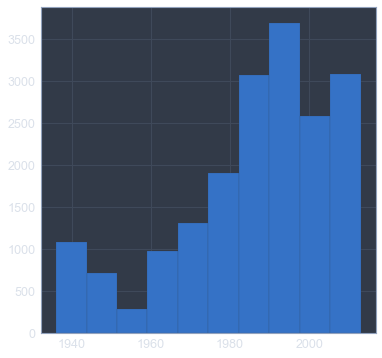

In [12]:
# ooh pretty plots. 
all_data['YEAR'].hist(figsize=(6,6));

In [25]:
# Get dummy columns for categorical data. My learning model requires numeric features to work. This 
# allows us to specify Brown Eyes == 1, for example, to indicate that the given character has brown
# eyes without breaking the model. We use drop_first to get rid of the first instance of each feature 
# which is redundant. Example: if eyes can be black blue or brown, we don't need a black column. 
# If blue or brown or not blue or brown, black is known.

final = pd.get_dummies(all_data, columns=['ID', 'EYE', 'HAIR', 'SEX', 'GSM', 'ALIVE'], drop_first=True)
final

,page_id,name,urlslug,ALIGN,APPEARANCES,FIRST APPEARANCE,YEAR,ID_Known to Authorities Identity,ID_No Dual Identity,ID_Public Identity,...,SEX_Transgender Characters,SEX_Unknown Sex,GSM_Genderfluid Characters,GSM_Homosexual Characters,GSM_Pansexual Characters,GSM_Transgender Characters,GSM_Transvestites,GSM_Unknown Orientation,ALIVE_Living Characters,ALIVE_Unknown
0,1422,Batman (Bruce Wayne),\/wiki\/Batman_(Bruce_Wayne),Good Characters,3093.0,"1939, May",1939.0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,23387,Superman (Clark Kent),\/wiki\/Superman_(Clark_Kent),Good Characters,2496.0,"1986, October",1986.0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,1458,Green Lantern (Hal Jordan),\/wiki\/Green_Lantern_(Hal_Jordan),Good Characters,1565.0,"1959, October",1959.0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,1659,James Gordon (New Earth),\/wiki\/James_Gordon_(New_Earth),Good Characters,1316.0,"1987, February",1987.0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
4,1576,Richard Grayson (New Earth),\/wiki\/Richard_Grayson_(New_Earth),Good Characters,1237.0,"1940, April",1940.0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18725,625364,Visher-Rakk (Earth-616),\/Visher-Rakk_(Earth-616),Bad Characters,1.0,Unknown,1989.0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
18726,708936,Weapon Red (Chinese Mutant) (Earth-616),\/Weapon_Red_(Chinese_Mutant)_(Earth-616),Bad Characters,1.0,Unknown,1989.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
18727,633140,Wolfgang von Roehm (Earth-616),\/Wolfgang_von_Roehm_(Earth-616),Neutral Characters,1.0,Unknown,1989.0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
18728,715281,Xan (Earth-616),\/Xan_(Earth-616),Bad Characters,1.0,Unknown,1989.0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [26]:
# Pick the features that will be used to predict our target dropping stuff that doesn't matter, 
# and dropping the target itself.
features = final.drop(['name', 'page_id', 'urlslug', 'FIRST APPEARANCE', 'ALIGN'], axis=1)
target = final['ALIGN']

In [15]:
# Random Forest is one of many classification models, but this one is pretty popular due to its
# accuracy. Most models in sklearn use EXACTLY this same method whether you are trying to do 
# classification or regression.

# Create an instance of the model. 
forest = RandomForestClassifier()

# Split data into testing and training subsets. random_state makes it so anyone running this will get
# the same result every time the code is run. If you leave it blank, you'll get a slightly different
# result every time since train/test/split will split up your data differently. test_size indicates 
# that I want 30% of my data to be reserved for testing. You can try playing with this number to see
# how it changes results, but rule of thumb is 25-30%.
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                           target,
                                                                           random_state=42,
                                                                           test_size=.30)
# Train the model.
forest.fit(features_train, target_train)
# Make predictions on the features we chose.
target_pred = forest.predict(features_test)
# Score it. 
print(metrics.classification_report(target_test, target_pred))

                    precision    recall  f1-score   support

    Bad Characters       0.62      0.68      0.65      2670
   Good Characters       0.55      0.56      0.55      2124
Neutral Characters       0.25      0.15      0.19       825

          accuracy                           0.56      5619
         macro avg       0.47      0.46      0.46      5619
      weighted avg       0.54      0.56      0.55      5619



Precision = True positives / actual results <br>
Recall = True positives / predicted results <br>
Accuracy = True positives + true negatives / total <br>
f1-score = "harmonic mean" between precision and recall; tries to balance between both.<br><br>

The closer to 1 your scores are, the better the model is performing. Which score to pay the most attention to depends on the purpose of your model. For example, false negatives are a really bad thing if you're trying to predict the presence of disease.<br><br>

In this case, there are 3 possible categories we are trying to predict. So, when we consider that our "best guess" is 33% likely to be accurate (I randomly choose good/bad/neutral) this model is actually performing quite well for Bad and Good characters! We're not doing very well with netural characters probably because we don't have nearly as many examples with which to train our data. <br><br>

We could try to fix this by oversampling the Neutral Characters or undersampling the other classes. Or, we could lump the neutral characters in with one of the other classes to make the model predict good vs. not good, or bad vs. not bad rather than trying to figure out if the character is neutral. Going to take a stab at this tomorrow.

In [19]:
# Making all neutral characters good. Re-import and concat data before running.

all_data['ALIGN'].replace('Neutral Characters', 'Good Characters', inplace=True)
final = pd.get_dummies(all_data, columns=['ID', 'EYE', 'HAIR', 'SEX', 'GSM', 'ALIVE'], drop_first=True)
features = final.drop(['name', 'page_id', 'urlslug', 'FIRST APPEARANCE', 'ALIGN'], axis=1)
target = final['ALIGN']

forest = RandomForestClassifier()

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                           target,
                                                                           random_state=42,
                                                                           test_size=.30)

forest.fit(features_train, target_train)
target_pred = forest.predict(features_test) 
print(metrics.classification_report(target_test, target_pred))

                 precision    recall  f1-score   support

 Bad Characters       0.63      0.64      0.63      2670
Good Characters       0.67      0.66      0.67      2949

       accuracy                           0.65      5619
      macro avg       0.65      0.65      0.65      5619
   weighted avg       0.65      0.65      0.65      5619



In [42]:
# Making netural characters bad. Re-import and concat data before running.

all_data['ALIGN'].replace('Neutral Characters', 'Bad Characters', inplace=True)
final = pd.get_dummies(all_data, columns=['ID', 'EYE', 'HAIR', 'SEX', 'GSM', 'ALIVE'], drop_first=True)
features = final.drop(['name', 'page_id', 'urlslug', 'FIRST APPEARANCE', 'ALIGN'], axis=1)
target = final['ALIGN']

forest = RandomForestClassifier()

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                           target,
                                                                           random_state=42,
                                                                           test_size=.30)

forest.fit(features_train, target_train)
target_pred = forest.predict(features_test) 
print(metrics.classification_report(target_test, target_pred))

                 precision    recall  f1-score   support

 Bad Characters       0.72      0.77      0.74      3495
Good Characters       0.57      0.50      0.53      2124

       accuracy                           0.67      5619
      macro avg       0.64      0.63      0.64      5619
   weighted avg       0.66      0.67      0.66      5619



In [28]:
# Drop neutral characters. Re-import and concat data before running.

all_data = all_data[all_data['ALIGN'] != 'Neutral Characters'].reset_index(drop=True)
final = pd.get_dummies(all_data, columns=['ID', 'EYE', 'HAIR', 'SEX', 'GSM', 'ALIVE'], drop_first=True)
features = final.drop(['name', 'page_id', 'urlslug', 'FIRST APPEARANCE', 'ALIGN'], axis=1)
target = final['ALIGN']

forest = RandomForestClassifier()

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                           target,
                                                                           random_state=42,
                                                                           test_size=.30)

forest.fit(features_train, target_train)
target_pred = forest.predict(features_test) 
print(metrics.classification_report(target_test, target_pred))

                 precision    recall  f1-score   support

 Bad Characters       0.70      0.74      0.72      2722
Good Characters       0.64      0.59      0.62      2104

       accuracy                           0.68      4826
      macro avg       0.67      0.67      0.67      4826
   weighted avg       0.68      0.68      0.68      4826



Making neutral characters bad works well 